Evaluating Sentiment Analysis Models on IMDB Reviews: A Focus on Performance and Calibration

First, we install the necesary packages :

In [1]:
! pip install scikit-learn nltk gensim spacy pandas transformers[torch] torch datasets accelerate uncertainty-calibration -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0

Loading the dataset, from Huggingface Datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
from sklearn.model_selection import train_test_split

# training and test sets
train_set = dataset["train"]
test_set = dataset["test"]

# Get the text and labels for training and test sets
train_text, y_train = [example['text'] for example in train_set], [example['label'] for example in train_set]
test_text, y_test = [example['text'] for example in test_set], [example['label'] for example in test_set]

print(len(train_text),len(test_text))#,len(valid_text))

25000 25000


Now, we preprocess the data :

In [4]:
import pandas as pd
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re


def preprocess_text(text):
    text = re.sub('<[^>]*>', '', text)  # Remove HTML tags
    text = re.sub('[\W]+', ' ', text.lower())  # Remove punctuation and lowercase
    stop_words = stopwords.words('english')
    porter = PorterStemmer()
    tokens = [word for word in text.split() if word not in stop_words]  # Tokenization and stopword removal
    stemmed = [porter.stem(word) for word in tokens]  # Stemming
    return ' '.join(stemmed)

# Apply preprocessing to each document in the train and test sets
X_train_preprocessed = [preprocess_text(doc) for doc in train_text]
X_test_preprocessed = [preprocess_text(doc) for doc in test_text]
#X_valid_preprocessed = [preprocess_text(doc) for doc in valid_text]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
print(len(train_text),len(test_text))

25000 25000


Now we start fitting our classifiers. First one is the Logisitic Regression.

## Logistic Regression

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Create a processing pipeline with CountVectorizer and LogisticRegression
vectorizer = TfidfVectorizer()
clf = LogisticRegression(class_weight='balanced')
pipeline = make_pipeline(vectorizer,clf)

# Fit the model on the training data
pipeline.fit(X_train_preprocessed, y_train)

# You can now use the pipeline to predict sentiment on new data
# and evaluate its performance using `pipeline.score(X_test, y_test)` and other metrics.


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [8]:
y_pred_lr = pipeline.predict(X_test_preprocessed)

Accuracy: 0.8792


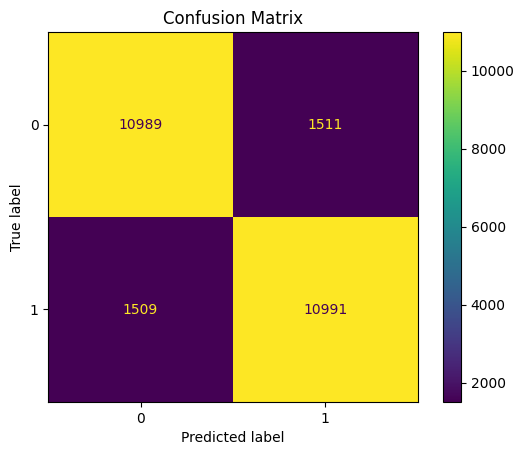

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy}")

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title('Confusion Matrix')
plt.show()


In [10]:
y_probs_lr = pipeline.predict_proba(X_test_preprocessed)

In [11]:
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss

# Calculate Brier Score for binary classification
brier_score = brier_score_loss(y_test, y_probs_lr[:, 1])  # Assuming positive class is at index 1
print(f"Brier Score: {brier_score}")

# Calculate Log Loss / NLL
nll = log_loss(y_test, y_probs_lr)
print(f"Negative Log-Likelihood (Log Loss): {nll}")



Brier Score: 0.09648874723922743
Negative Log-Likelihood (Log Loss): 0.323026810257285


We perform a grid search for the best parameters and then use the best estimator to predict.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline combining a text vectorizer with logistic regression
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression())

# Define the parameter grid to search over
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'logisticregression__class_weight': [None, 'balanced'], # Class weight options
    'logisticregression__max_iter': [1000]
}

# Set up GridSearchCV to find the best parameters (including the best C)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the training data
grid_search.fit(X_train_preprocessed, y_train)

# Print the best parameters and the best score achieved
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (accuracy):", grid_search.best_score_)


Best parameters: {'logisticregression__C': 1, 'logisticregression__class_weight': None, 'logisticregression__max_iter': 1000}
Best cross-validation score (accuracy): 0.8568800000000001


In [13]:
y_pred_lr = grid_search.best_estimator_.predict(X_test_preprocessed)

y_probs_lr = grid_search.best_estimator_.predict_proba(X_test_preprocessed)

Accuracy: 0.8792


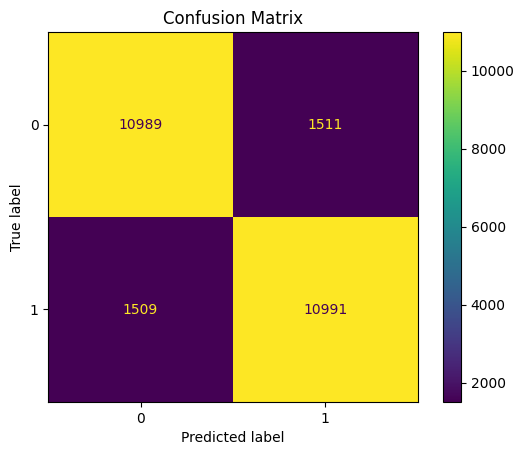

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy}")



# Visualizing the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title('Confusion Matrix')
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss

# Calculate Brier Score for binary classification
brier_score = brier_score_loss(y_test, y_probs_lr[:, 1])  # Assuming positive class is at index 1
print(f"Brier Score: {brier_score}")

# Calculate Log Loss / NLL
nll = log_loss(y_test, y_probs_lr)
print(f"Negative Log-Likelihood (Log Loss): {nll}")

import calibration as cal
calibration_error = cal.get_ece(y_probs_lr, y_test)
print(calibration_error)

[lower, _, upper] = cal.get_calibration_error_uncertainties(y_probs_lr, y_test)

print(lower,upper)

Brier Score: 0.09648874723922743
Negative Log-Likelihood (Log Loss): 0.323026810257285
0.08294340700254987
0.08608174701544755 0.09584200157134845


## SVM

Now, we implement the Support Vector Classifier.

(for reasons due to compute time and resources intensiveness, we are unable to perform a GRID search on this model, so we custom select hyperparameters that we think will induce the best performance

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline combining a text vectorizer with logistic regression
pipeline = make_pipeline(TfidfVectorizer(), SVC(kernel = 'linear',probability=True))

# Define the parameter grid to search over
#param_grid = {
#    'svc__C': [0.1, 1, 10],  # Regularization parameter C
#    'svc__kernel': ['linear','sigmoid']
#}

# Set up GridSearchCV to find the best parameters (including the best C)
#grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
pipeline.fit(X_train_preprocessed,y_train)
# Perform the grid search on the training data
#grid_search.fit(X_train_preprocessed, y_train)

y_pred_svm = pipeline.predict(X_test_preprocessed)

y_probs_svm = pipeline.predict_proba(X_test_preprocessed)

Test Accuracy: 0.87212


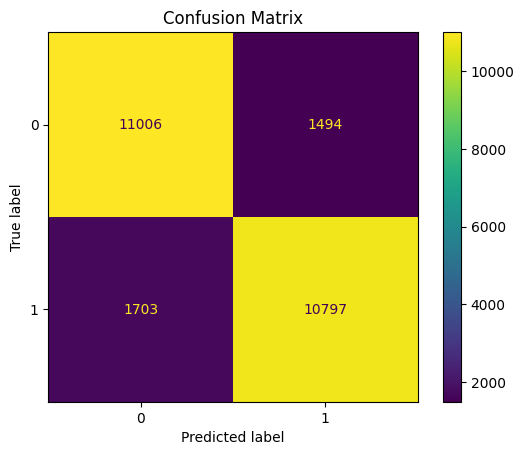

In [17]:
# confusion matrix
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy: {accuracy}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title('Confusion Matrix')
plt.show()

In [18]:
calibration_error = cal.get_ece(y_probs_svm, y_test)
print(calibration_error)

0.00602562008616888


## Naive Bayes


In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Initialize the Multinomial Naive Bayes classifier

clf = MultinomialNB()
vectorizer = TfidfVectorizer()
pipeline = make_pipeline(vectorizer,clf)

# Train classifier
pipeline.fit(X_train_preprocessed, y_train)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer()
clf = MultinomialNB()

# Create a pipeline
pipeline = make_pipeline(vectorizer, clf)

# Define the parameter grid
parameters = {
    'multinomialnb__alpha': [1.0, 0.1, 0.01]
}

# Setup the grid search
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train_preprocessed, y_train)

# Best model after grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred_nb = best_model.predict(X_test_preprocessed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy : {accuracy:.4f}")


Accuracy : 0.8223


In [21]:
y_probs_nb = best_model.predict_proba(X_test_preprocessed)

In [22]:
calibration_error = cal.get_ece(y_probs_nb, y_test)
print(calibration_error)

0.11698173774133923


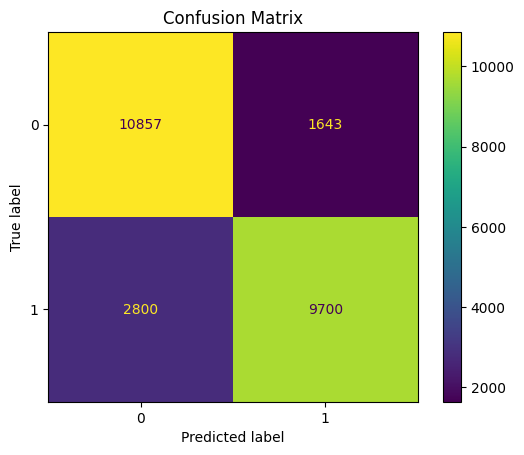

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb)
plt.title('Confusion Matrix')
plt.show()

In [24]:
print(classification_report(y_pred=y_pred_nb,y_true=y_test))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     12500
           1       0.86      0.78      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



## Random Forests


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

pipeline = make_pipeline(vectorizer,clf)

# Train the classifier
pipeline.fit(X_train_preprocessed, y_train)



Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)

pipeline = make_pipeline(vectorizer,rf)

param_grid = {
    'randomforestclassifier__n_estimators': [25, 50, 100],  # Number of trees in the forest
    'randomforestclassifier__max_depth': [None, 10, 20],  # Maximum depth of the tree
}


grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

# Fit
grid_search.fit(X_train_preprocessed, y_train)

print("Best parameters found: ", grid_search.best_params_)

#best estimator
best_rf = grid_search.best_estimator_

# Predict
y_pred_rf = best_rf.predict(X_test_preprocessed)

# Probabilities
y_probs_rf = best_rf.predict_proba(X_test_preprocessed)

accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy : {accuracy:.4f}")


Best parameters found:  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 100}
Accuracy : 0.8447


In [27]:
calibration_error = cal.get_ece(y_probs_rf, y_test)
print(calibration_error)

0.18685960000000001


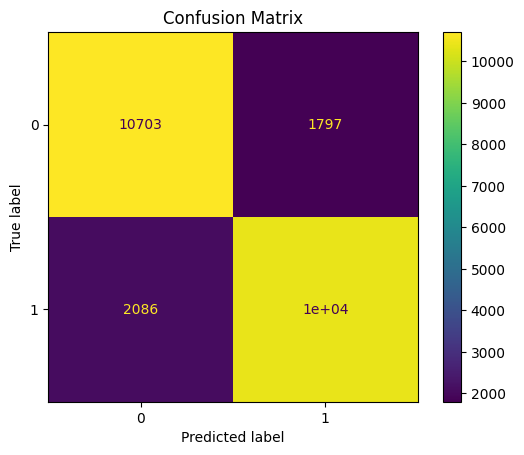

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('Confusion Matrix')
plt.show()

In [29]:
print(classification_report(y_pred=y_pred_rf,y_true=y_test))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Initialize the AdaBoost classifier
clf = AdaBoostClassifier(n_estimators=100, random_state=42)

pipeline = make_pipeline(vectorizer,clf)

# Train the classifier
pipeline.fit(X_train_preprocessed, y_train)




Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('adaboostclassifier',
                 AdaBoostClassifier(n_estimators=100, random_state=42))])

In [ ]:
y_probs_ab = pipeline.predict_proba(X_test_preprocessed)

In [ ]:
# Predict on the test set
y_pred_ab = pipeline.predict(X_test_preprocessed)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_ab)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.82948


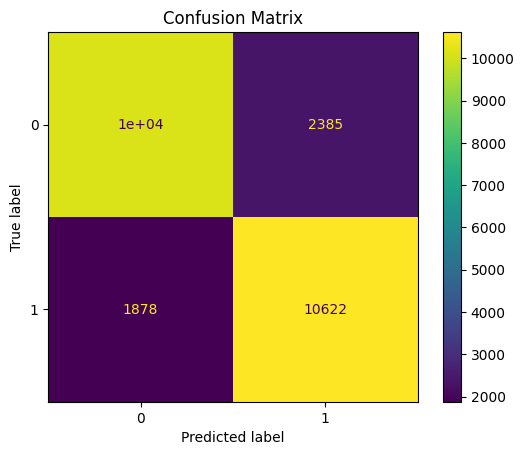

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ab)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_pred = y_pred_ab,y_true = y_test))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     12500
           1       0.82      0.85      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



## BERT


In [30]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained("jdorairaj/Bert-uncased-imdb-finetuned") #jdorairaj/Bert-uncased-imdb-finetuned

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [31]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader


#dataset = load_dataset('imdb', split='test')

tokenizer = BertTokenizer.from_pretrained("jdorairaj/Bert-uncased-imdb-finetuned")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = test_set.map(tokenize_function, batched=True)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


test_dataset = tokenized_datasets.remove_columns(["text"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Initializing the DataLoader

test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=16, collate_fn=data_collator)

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [32]:
print(test_dataloader.dataset)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})


In [33]:
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss, brier_score_loss

def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    #data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    eval_dataloader = test_dataloader #DataLoader(tokenized_dataset, batch_size=16, collate_fn=data_collator)

    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for step_num, batch_data in enumerate(eval_dataloader):
            #print(batch_data)

            input_ids = batch_data['input_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            labels = batch_data['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            #logits = model(token_ids, masks)
            #logits = logits.cpu().detach().numpy()
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
            predictions.extend(probs[:, 1])
            references.extend(batch_data['labels'].cpu().numpy())

    # Calculate metrics
    preds = np.array(predictions) >= 0.5
    accuracy = accuracy_score(references, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(references, preds, average='binary')
    nll = log_loss(references, predictions)
    brier = brier_score_loss(references, predictions)

    metrics = {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall, "nll": nll, "brier_score": brier}
    return metrics, predictions, preds, references

# Evaluate the model
metrics, predictions, y_pred_bert, references  = evaluate_model(model, test_dataloader)

# Print/save metrics
print(metrics)

# Optionally, save the predictions
#np.savetxt("predictions.txt", np.array(predictions))


{'accuracy': 0.9404, 'f1': 0.9403331731539324, 'precision': 0.9413887107119948, 'recall': 0.93928, 'nll': 0.20931009151551752, 'brier_score': 0.05154325507272467}


In [34]:
calibration_error = cal.get_ece(predictions, references)
print(calibration_error)

0.04175691936910149


In [ ]:
! git config --global credential.helper store
! huggingface-cli login


## Plotting and creating table

In [ ]:
from collections import defaultdict
from calibration import get_calibration_error
import numpy as np

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score
)

y_probs = [y_probs_lr[:,1], y_probs_svm[:,1], y_probs_nb[:,1], y_probs_rf[:,1], predictions]
y_preds = [y_pred_lr,y_pred_svm,y_pred_nb,y_pred_rf,y_pred_bert]
y_tests = [y_test,y_test,y_test,y_test,references]

# Names for your models to use in the legend
model_names = ["Logistic Regression", "SVC", "Naive Bayes", "Random Forest", "BERT"]

scores = defaultdict(list)
for y_prob, name, y_pred,true_labels in zip(y_probs, model_names,y_preds,y_tests):
    #clf.fit(X_train_vectorized, y_train)
    #y_prob = clf.predict_proba(X_test_vectorized)
    #y_pred = clf.predict(X_test_vectorized)
    scores["Classifier"].append(name)
    true_labels = np.array(true_labels, dtype=np.int32)
    #print(type(true_labels))


    for metric in [brier_score_loss, log_loss]: #,get_calibration_error
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(true_labels, y_prob))

    for metric in [precision_score, recall_score, f1_score, accuracy_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(true_labels, y_pred))


    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Precision,Recall,F1,Accuracy
Classifier,,,,,,
Logistic Regression,0.096489,0.323027,0.879139,0.87928,0.879210,0.87920
SVC,0.092100,0.300668,0.878448,0.86376,0.871042,0.87212
Naive Bayes,0.141530,0.449360,0.855153,0.77600,0.813656,0.82228
Random Forest,0.150025,0.478071,0.852838,0.83312,0.842864,0.84468
BERT,0.051543,0.209310,0.941389,0.93928,0.940333,0.94040


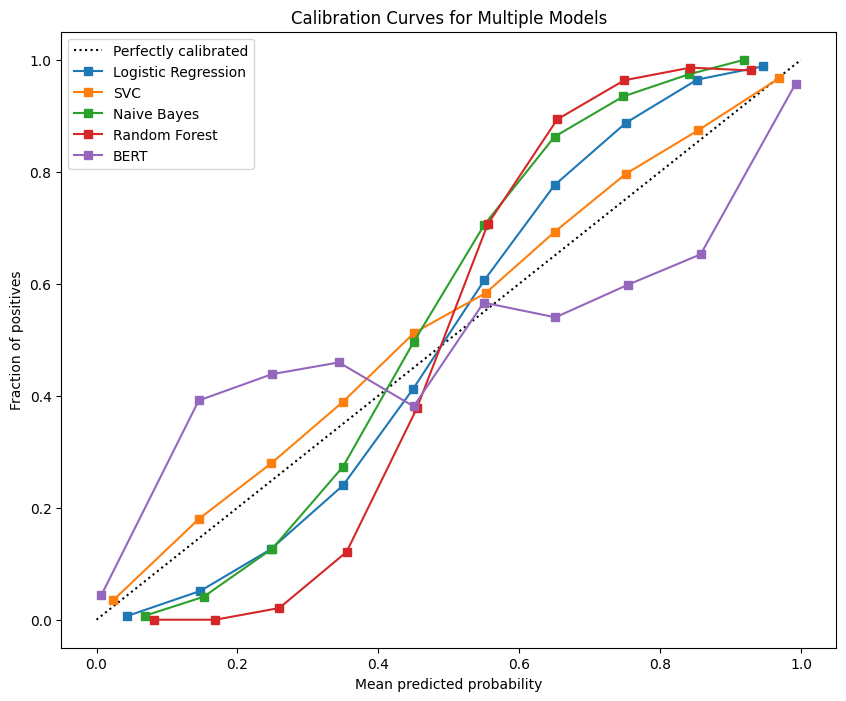

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Example data structure
y_probs = [y_probs_lr[:,1], y_probs_svm[:,1], y_probs_nb[:,1], y_probs_rf[:,1], predictions]
y_tests = [y_test,y_test,y_test,y_test,references]


# Names for your models to use in the legend
model_names = ["Logistic Regression", "SVC", "Naive Bayes", "Random Forest", "BERT","Adaboost"]

# Setting up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for y_prob, name,true_labels in zip(y_probs, model_names,y_tests):
    fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, y_prob, n_bins=10, strategy='uniform')

    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}")

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves for Multiple Models')
plt.legend()
plt.show()


In [ ]:
plt.savefig('calibration_curve.png', dpi=500)

<Figure size 640x480 with 0 Axes>